<a href="https://colab.research.google.com/github/HHL43/Generative-AI-HW/blob/main/AI_hw07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG系統的財經小幫手

# 示意圖
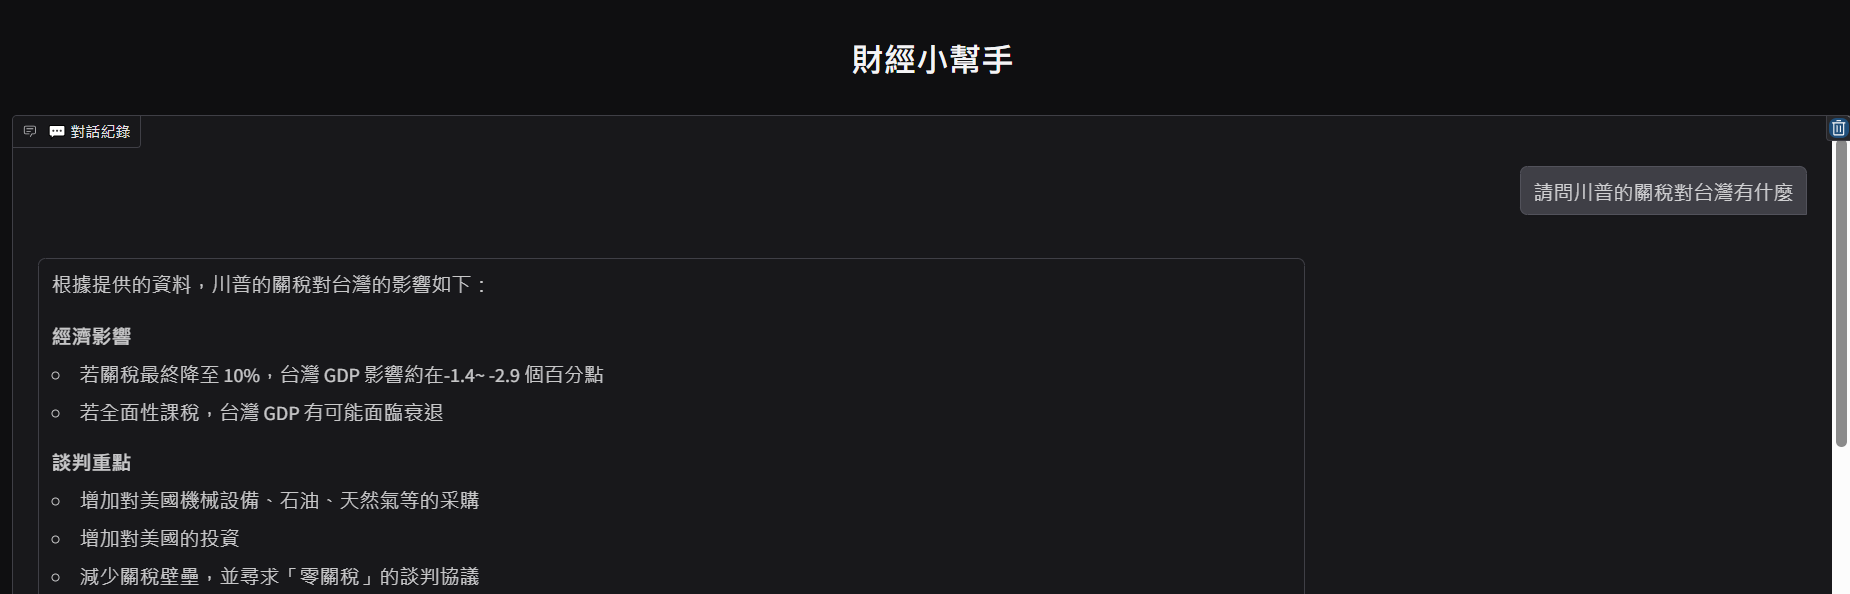

In [1]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from openai import OpenAI
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/8

In [3]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

In [18]:
!curl -L -o faiss_db.zip "https://drive.google.com/uc?export=download&id=1inZQk9nYTYsqLai4CZ4mFOZ_4mOkDgY1"
!unzip faiss_db.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 92092  100 92092    0     0  40295      0  0:00:02  0:00:02 --:--:-- 47154
Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


In [19]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [20]:
import os
from google.colab import userdata
api_key = userdata.get('Groq')
os.environ["OPENAI_API_KEY"] = api_key
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"
client = OpenAI(
    base_url=base_url
)

In [24]:
system_prompt = "你是一位專業的財經分析師，請根據提供的資料準確回答使用者的問題，避免發揮或猜測。請使用繁體中文回答。"

prompt_template = """
你是一位財經專家，以下是你需要參考的資料：

【資料內容開始】
{retrieved_chunks}
【資料內容結束】

請根據上述資料，回答使用者的問題。
如果資料中沒有足夠的資訊，請明確表示「根據目前資料無法回答」。

使用者的問題是：
「{question}」

請以條列或清晰的段落格式作答，並保持專業與客觀。
"""

In [22]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

In [27]:
import gradio as gr

with gr.Blocks(css="""
    #title {
        text-align: center;
        font-size: 32px;
        font-weight: bold;
        color: #1f4e79;
        margin-top: 20px;
        margin-bottom: 10px;
    }

    .gr-chatbot {
        border: 1px solid #ccc !important;
        border-radius: 12px !important;
        padding: 8px;
        background-color: #f9f9f9;
    }

    .gr-textbox textarea {
        border-radius: 8px !important;
        border: 1px solid #888 !important;
        font-size: 16px;
        padding: 10px;
    }

    button {
        background-color: #1f4e79 !important;
        color: white !important;
        border-radius: 6px !important;
    }

""") as demo:
    gr.Markdown("# 財經小幫手", elem_id="title")

    chatbot = gr.Chatbot(label="💬 對話紀錄")

    msg = gr.Textbox(placeholder="請輸入你的問題...", lines=2, label="輸入問題")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)


<ipython-input-27-1f9592d6eb53>:36: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="💬 對話紀錄")


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://88cfbef5c823fccfdc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://88cfbef5c823fccfdc.gradio.live


In [29]:
!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --clear-output your_notebook.ipynb --to notebook --output cleaned_notebook.ipynb


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 